In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)
import pickle

In [2]:
df = pd.read_csv("../Data/indian_liver_patient_clean.csv")
df.dropna(inplace=True)
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Dataset'] = df['Dataset'].map({1:1, 2:0})

X = df.drop('Dataset', axis=1)
y = df['Dataset']

# Splitting and scaling the features for model input
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=64, stratify=y
)

In [3]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=64),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
}

print("Models ready to train:", list(models.keys()))

Models ready to train: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'XGBoost']


In [4]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })


Logistic Regression
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        33
           1       0.72      0.91      0.80        75

    accuracy                           0.69       108
   macro avg       0.61      0.56      0.55       108
weighted avg       0.66      0.69      0.65       108

Confusion Matrix:
 [[ 7 26]
 [ 7 68]]

Decision Tree
              precision    recall  f1-score   support

           0       0.48      0.36      0.41        33
           1       0.75      0.83      0.78        75

    accuracy                           0.69       108
   macro avg       0.61      0.60      0.60       108
weighted avg       0.67      0.69      0.67       108

Confusion Matrix:
 [[12 21]
 [13 62]]

Random Forest
              precision    recall  f1-score   support

           0       0.47      0.27      0.35        33
           1       0.73      0.87      0.79        75

    accuracy                           0.69       108
 

In [5]:
# Random Forest hyperparameter tuning
rf = RandomForestClassifier(random_state=64)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, y_train)

rf_default = RandomForestClassifier(random_state=64).fit(X_train, y_train)
rf_f1_default = f1_score(y_test, rf_default.predict(X_test))
rf_f1_tuned = f1_score(y_test, grid_rf.best_estimator_.predict(X_test))

print("Random Forest best parameters:", grid_rf.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Random Forest best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [6]:
# XGBoost hyperparameter tuning
scale = (len(y_train) - y_train.sum()) / y_train.sum()

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=64,
    scale_pos_weight=scale
)

params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

grid_xgb = GridSearchCV(
    xgb,
    params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train, y_train)

probs = grid_xgb.best_estimator_.predict_proba(X_test)[:, 1]

best_thr, best_score = 0, 0
for thr in np.linspace(0, 1, 101):
    y_thr = (probs >= thr).astype(int)
    score = f1_score(y_test, y_thr, average='macro', zero_division=0)
    if score > best_score:
        best_score, best_thr = score, thr

print("XGBoost best parameters:", grid_xgb.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [7]:
lr_default = LogisticRegression(max_iter=1000)
rf_default = RandomForestClassifier(random_state=64)
xgb_default = XGBClassifier(eval_metric='logloss', random_state=64)
rf_tuned = grid_rf.best_estimator_
xgb_tuned = grid_xgb.best_estimator_
nb_model = GaussianNB()
dt_model = DecisionTreeClassifier()


Logistic Regression
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        33
           1       0.72      0.91      0.80        75

    accuracy                           0.69       108
   macro avg       0.61      0.56      0.55       108
weighted avg       0.66      0.69      0.65       108



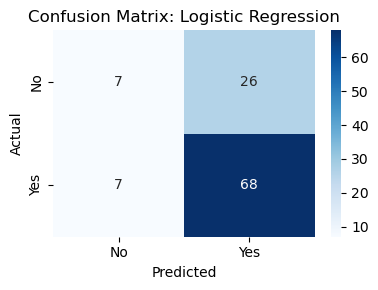


Decision Tree
              precision    recall  f1-score   support

           0       0.58      0.42      0.49        33
           1       0.77      0.87      0.82        75

    accuracy                           0.73       108
   macro avg       0.68      0.65      0.65       108
weighted avg       0.72      0.73      0.72       108



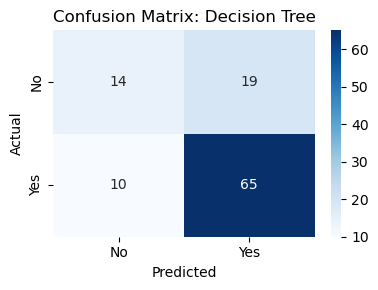


Random Forest
              precision    recall  f1-score   support

           0       0.47      0.27      0.35        33
           1       0.73      0.87      0.79        75

    accuracy                           0.69       108
   macro avg       0.60      0.57      0.57       108
weighted avg       0.65      0.69      0.66       108



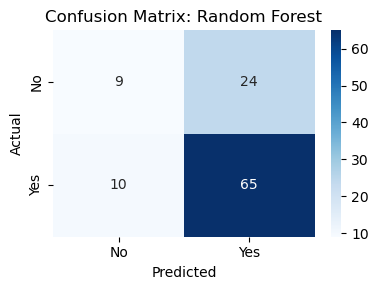


Naive Bayes
              precision    recall  f1-score   support

           0       0.42      0.94      0.58        33
           1       0.94      0.43      0.59        75

    accuracy                           0.58       108
   macro avg       0.68      0.68      0.58       108
weighted avg       0.78      0.58      0.58       108



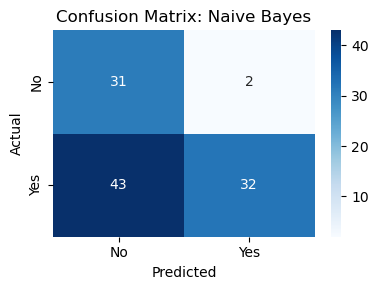


XGBoost
              precision    recall  f1-score   support

           0       0.52      0.33      0.41        33
           1       0.75      0.87      0.80        75

    accuracy                           0.70       108
   macro avg       0.64      0.60      0.60       108
weighted avg       0.68      0.70      0.68       108



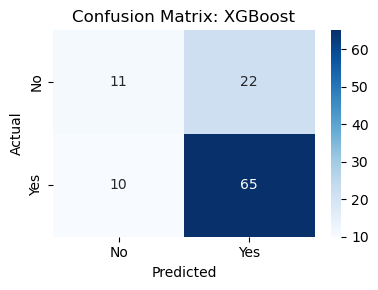


RF_Tuned
              precision    recall  f1-score   support

           0       0.44      0.21      0.29        33
           1       0.72      0.88      0.79        75

    accuracy                           0.68       108
   macro avg       0.58      0.55      0.54       108
weighted avg       0.63      0.68      0.64       108



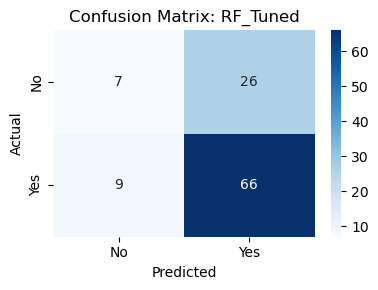


XGB_Tuned
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        33
           1       0.76      0.76      0.76        75

    accuracy                           0.67       108
   macro avg       0.61      0.61      0.61       108
weighted avg       0.67      0.67      0.67       108



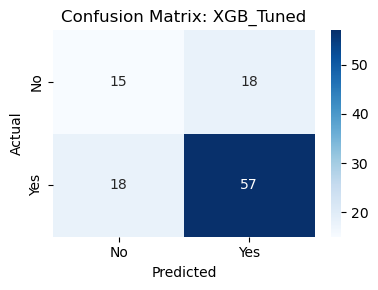


All model results (10 Features):


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.694444,0.723404,0.906667,0.804734
1,Decision Tree,0.731481,0.773810,0.866667,0.817610
2,Random Forest,0.685185,0.730337,0.866667,0.792683
3,Naive Bayes,0.583333,0.941176,0.426667,0.587156
4,XGBoost,0.703704,0.747126,0.866667,0.802469
5,RF_Tuned,0.675926,0.717391,0.880000,0.790419
6,XGB_Tuned,0.666667,0.760000,0.760000,0.760000


In [8]:
models_before = {
    "Logistic Regression": lr_default,
    "Decision Tree": dt_model,
    "Random Forest": rf_default,
    "Naive Bayes": nb_model,
    "XGBoost": xgb_default,
    "RF_Tuned": grid_rf.best_estimator_,
    "XGB_Tuned": grid_xgb.best_estimator_
}

results = []

for name, model in models_before.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['No','Yes'], yticklabels=['No','Yes']
    )
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    })

results_df = pd.DataFrame(results)
print("\nAll model results (10 Features):")
display(results_df)


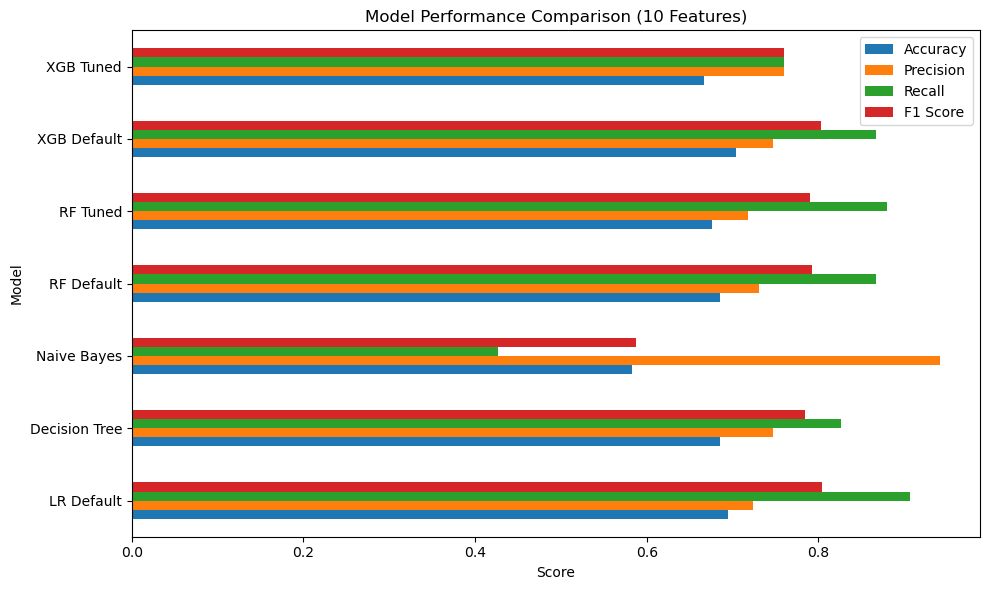

In [9]:
model_dict = {
    'LR Default': lr_default,
    'Decision Tree': dt_model,
    'Naive Bayes': nb_model,
    'RF Default': rf_default,
    'RF Tuned': grid_rf.best_estimator_,
    'XGB Default': xgb_default,
    'XGB Tuned': grid_xgb.best_estimator_
}

results = []
for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    })

df_results = pd.DataFrame(results).set_index('Model')

ax = df_results.plot.barh(figsize=(10, 6))
ax.set_xlabel('Score')
ax.set_title('Model Performance Comparison (10 Features)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [10]:
features = df.drop('Dataset', axis=1).columns.tolist()

X = df[features]
y = df['Dataset']

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training targets (liver disease labels): {y_train.shape}")

Training set shape: (430, 10), Test set shape: (108, 10)
Training targets (liver disease labels): (430,)


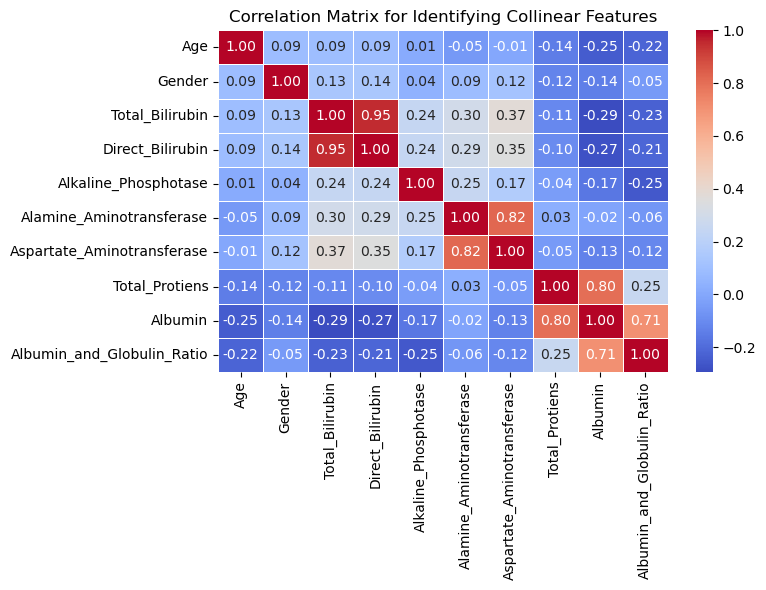

In [11]:
# Correlation matrix to identify collinear features before feature selection
train_df = pd.DataFrame(X_train, columns=X.columns)

plt.figure(figsize=(8,6))
sns.heatmap(
    train_df.corr(), 
    annot=True, fmt=".2f", 
    cmap="coolwarm", 
    linewidths=0.5
)
plt.title("Correlation Matrix for Identifying Collinear Features")
plt.tight_layout()
plt.show()

In [12]:
# Dropping Direct_Bilirubin, Alamine_Aminotransferase, and Total_Proteins
features_selected = [
    'Age', 'Gender', 'Total_Bilirubin', 'Alkaline_Phosphotase',
    'Aspartate_Aminotransferase', 'Albumin', 'Albumin_and_Globulin_Ratio'
]

X = df[features_selected]
y = df['Dataset']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Logistic Regression
              precision    recall  f1-score   support

           0       0.71      0.15      0.25        33
           1       0.72      0.97      0.83        75

    accuracy                           0.72       108
   macro avg       0.72      0.56      0.54       108
weighted avg       0.72      0.72      0.65       108



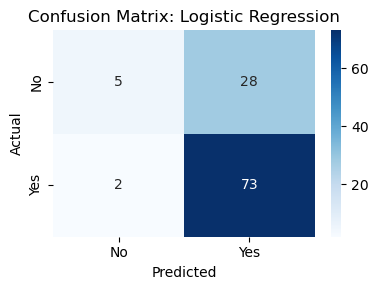


Decision Tree
              precision    recall  f1-score   support

           0       0.35      0.39      0.37        33
           1       0.72      0.68      0.70        75

    accuracy                           0.59       108
   macro avg       0.53      0.54      0.54       108
weighted avg       0.61      0.59      0.60       108



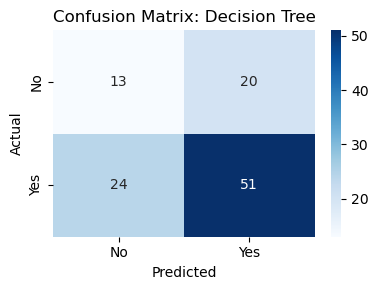


Random Forest
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        33
           1       0.72      0.87      0.79        75

    accuracy                           0.68       108
   macro avg       0.58      0.55      0.55       108
weighted avg       0.64      0.68      0.64       108



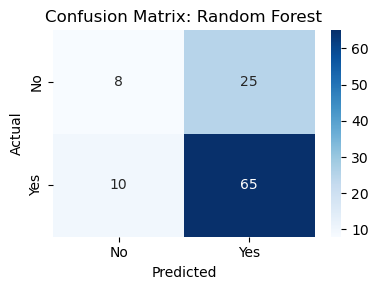


Naive Bayes
              precision    recall  f1-score   support

           0       0.47      0.91      0.62        33
           1       0.93      0.55      0.69        75

    accuracy                           0.66       108
   macro avg       0.70      0.73      0.65       108
weighted avg       0.79      0.66      0.67       108



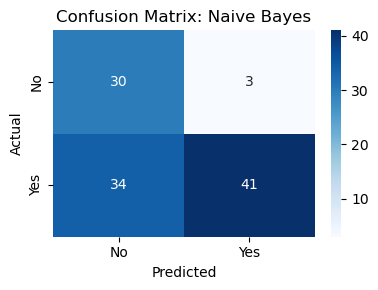


XGBoost
              precision    recall  f1-score   support

           0       0.35      0.24      0.29        33
           1       0.71      0.80      0.75        75

    accuracy                           0.63       108
   macro avg       0.53      0.52      0.52       108
weighted avg       0.60      0.63      0.61       108



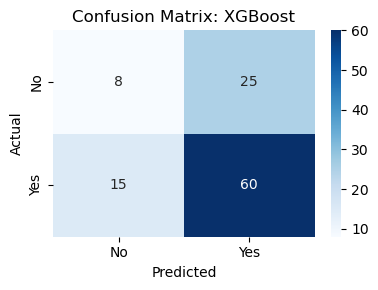


RF_Tuned
              precision    recall  f1-score   support

           0       0.36      0.15      0.21        33
           1       0.70      0.88      0.78        75

    accuracy                           0.66       108
   macro avg       0.53      0.52      0.50       108
weighted avg       0.60      0.66      0.61       108



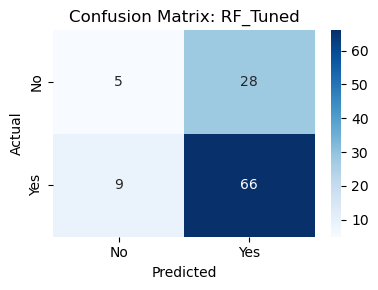


XGB_Tuned
              precision    recall  f1-score   support

           0       0.44      0.48      0.46        33
           1       0.76      0.73      0.75        75

    accuracy                           0.66       108
   macro avg       0.60      0.61      0.61       108
weighted avg       0.67      0.66      0.66       108



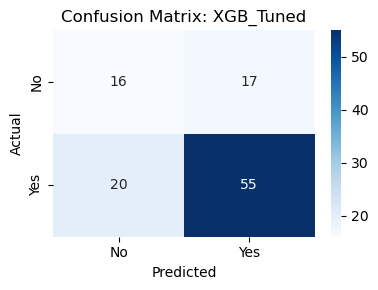


All model results (7 Features):


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.722222,0.722772,0.973333,0.829545
1,Decision Tree,0.592593,0.718310,0.680000,0.698630
2,Random Forest,0.675926,0.722222,0.866667,0.787879
3,Naive Bayes,0.657407,0.931818,0.546667,0.689076
4,XGBoost,0.629630,0.705882,0.800000,0.750000
5,RF_Tuned,0.657407,0.702128,0.880000,0.781065
6,XGB_Tuned,0.657407,0.763889,0.733333,0.748299


In [13]:
models_eval = {
    **models,
    'RF_Tuned': grid_rf.best_estimator_,
    'XGB_Tuned': grid_xgb.best_estimator_
}

results = []

for name, model in models_eval.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['No','Yes'], yticklabels=['No','Yes']
    )
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

results_df2 = pd.DataFrame(results)
print("\nAll model results (7 Features):")
display(results_df2)

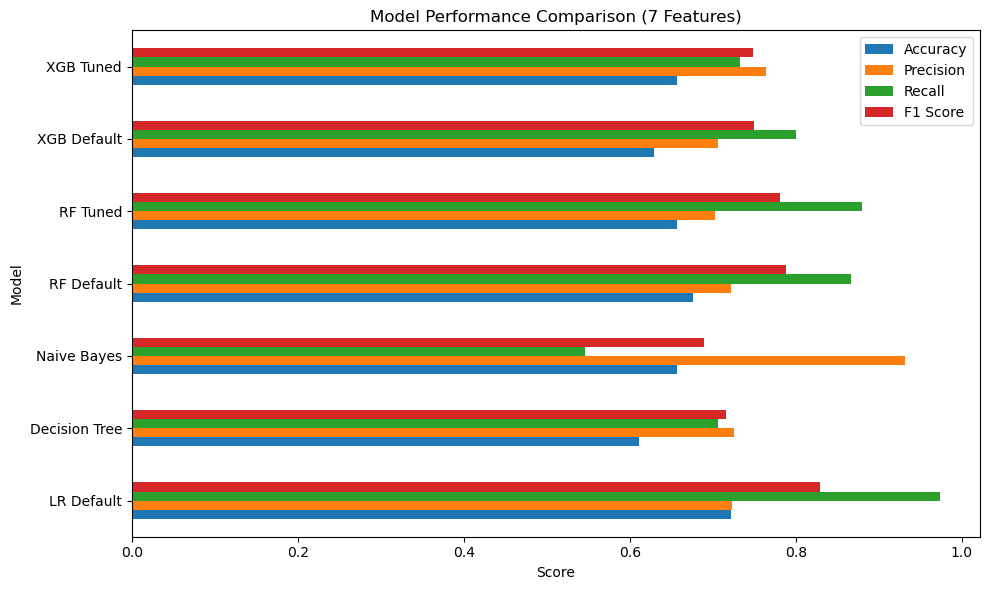

In [14]:
model_dict = {
    'LR Default': lr_default,
    'Decision Tree': dt_model,
    'Naive Bayes': nb_model,
    'RF Default': rf_default,
    'RF Tuned': grid_rf.best_estimator_,
    'XGB Default': xgb_default,
    'XGB Tuned': grid_xgb.best_estimator_
}

results = []
for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    })

df_results = pd.DataFrame(results).set_index('Model')

ax = df_results.plot.barh(figsize=(10, 6))
ax.set_xlabel('Score')
ax.set_title('Model Performance Comparison (7 Features)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

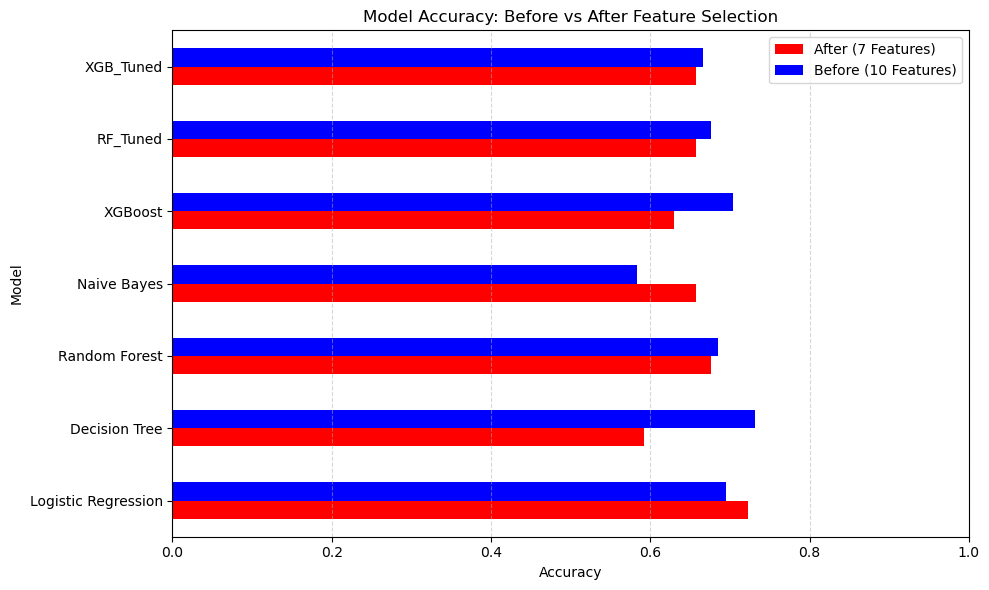

In [15]:
comparison_df = pd.merge(
    results_df[['Model', 'Accuracy']].rename(columns={'Accuracy': 'Before (10 Features)'}),
    results_df2[['Model', 'Accuracy']].rename(columns={'Accuracy': 'After (7 Features)'}),
    on='Model'
).set_index('Model')

ax = comparison_df[['After (7 Features)', 'Before (10 Features)']].plot(
    kind='barh', figsize=(10, 6), color=['red', 'blue']
)

ax.set_title("Model Accuracy: Before vs After Feature Selection")
ax.set_xlabel("Accuracy")
ax.set_xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [16]:
features_selected = [
    'Age', 'Gender', 'Total_Bilirubin', 'Alkaline_Phosphotase',
    'Aspartate_Aminotransferase', 'Albumin', 'Albumin_and_Globulin_Ratio'
]

X = df.drop(columns='Dataset')
y = df['Dataset']
X_sel = df[features_selected]

In [17]:
# 10-fold cross-validation
models_cv = {
    "LR Default": LogisticRegression(
    max_iter=5000,
    solver='liblinear',
    class_weight='balanced',
    random_state=64
), # Logistic Regression is configured to avoid convergence issues
    "Decision Tree": dt_model,
    "Naive Bayes": nb_model,
    "RF Default": rf_default,
    "RF Tuned": grid_rf.best_estimator_,
    "XGB Default": xgb_default,
    "XGB Tuned": grid_xgb.best_estimator_
}

cv_results = []

for name, model in models_cv.items():
    acc_before = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    f1_before = cross_val_score(model, X, y, cv=10, scoring='f1')

    acc_after = cross_val_score(model, X_sel, y, cv=10, scoring='accuracy')
    f1_after = cross_val_score(model, X_sel, y, cv=10, scoring='f1')

    cv_results.append({
        'Model': name,
        'CV Accuracy (Before Feature Selection)': np.mean(acc_before),
        'CV F1 Score (Before Feature Selection)': np.mean(f1_before),
        'CV Accuracy (After Feature Selection)': np.mean(acc_after),
        'CV F1 Score (After Feature Selection)': np.mean(f1_after)
    })

cv_df_combined = pd.DataFrame(cv_results).sort_values(by='CV F1 Score (After Feature Selection)', ascending=False)
display(cv_df_combined)

,Model,CV Accuracy (Before Feature Selection),CV F1 Score (Before Feature Selection),CV Accuracy (After Feature Selection),CV F1 Score (After Feature Selection)
4,RF Tuned,0.680398,0.783056,0.687841,0.788301
3,RF Default,0.682355,0.780450,0.669182,0.771344
5,XGB Default,0.676834,0.773159,0.663697,0.763046
1,Decision Tree,0.619078,0.718629,0.628197,0.733297
6,XGB Tuned,0.634137,0.700479,0.624808,0.687722
0,LR Default,0.639797,0.669824,0.619322,0.645093
2,Naive Bayes,0.576625,0.569390,0.582145,0.574690


In [18]:
# Creating a soft voting ensemble model using Default Logistic Regression, Tuned Random Forest, Tuned XGBoost
X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=64,
    stratify=y
)

lr = LogisticRegression(solver='lbfgs', C=1.0,
                          class_weight='balanced',
                          max_iter=1000, random_state=64)
rf = grid_rf.best_estimator_
xgbc = grid_xgb.best_estimator_
ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgbc)],
    voting='soft', n_jobs=-1
)
pipe = Pipeline([('ens', ensemble)])
pipe.fit(X_train_sel, y_train)

output_dir = os.path.join('..','Models')
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(
    output_dir,
    '1. Soft Voting Liver Ensemble (Default LR, Tuned RF, Tuned XGBoost).pkl'
)
with open(output_path, 'wb') as f:
    pickle.dump(pipe, f)

print(f"Ensemble pipeline saved at {output_path}")


Ensemble pipeline saved at ..\Models\1. Soft Voting Liver Ensemble (Default LR, Tuned RF, Tuned XGBoost).pkl


In [19]:
# Creating a soft voting ensemble model using Default Logistic Regression, Default Random Forest, Default XGBoost
X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=64,
    stratify=y
)

lr = LogisticRegression(solver='lbfgs', C=1.0,
                        class_weight='balanced',
                        max_iter=1000, random_state=64)
rf = RandomForestClassifier(random_state=64)
xgbc = XGBClassifier(eval_metric='logloss', random_state=64)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgbc)],
    voting='soft', n_jobs=-1
)
pipe = Pipeline([('ens', ensemble)])
pipe.fit(X_train_sel, y_train)

output_dir = os.path.join('..', 'Models')
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(
    output_dir,
    '2. Soft Voting Liver Ensemble (Default LR, Default RF, Default XGBoost).pkl'
)
with open(output_path, 'wb') as f:
    pickle.dump(pipe, f)

print(f"Ensemble pipeline saved at {output_path}")


Ensemble pipeline saved at ..\Models\2. Soft Voting Liver Ensemble (Default LR, Default RF, Default XGBoost).pkl


In [20]:
# Creating a hard voting ensemble model using Default Logistic Regression, Default Random Forest, Default XGBoost
X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=64,
    stratify=y
)

lr = LogisticRegression(solver='lbfgs', C=1.0,
                        class_weight='balanced',
                        max_iter=1000, random_state=64)
rf = RandomForestClassifier(random_state=64)
xgbc = XGBClassifier(eval_metric='logloss', random_state=64)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgbc)],
    voting='hard', n_jobs=-1
)
pipe = Pipeline([('ens', ensemble)])
pipe.fit(X_train_sel, y_train)

output_dir = os.path.join('..', 'Models')
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(
    output_dir,
    '3. Hard Voting Liver Ensemble (Default LR, Default RF, Default XGBoost).pkl'
)
with open(output_path, 'wb') as f:
    pickle.dump(pipe, f)

print(f"Ensemble pipeline saved at {output_path}")


Ensemble pipeline saved at ..\Models\3. Hard Voting Liver Ensemble (Default LR, Default RF, Default XGBoost).pkl
